In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Reading the Tables
conn = sqlite3.connect("healthcare.db")
appointments = pd.read_sql_query("SELECT * FROM appointments;", conn)
doctors = pd.read_sql_query("SELECT * FROM doctors;", conn)
patients = pd.read_sql_query("SELECT * FROM patients;", conn)
procedures = pd.read_sql_query("SELECT * FROM procedures;", conn)
prescriptions = pd.read_sql_query("SELECT * FROM prescriptions;", conn)
invoices = pd.read_sql_query("SELECT * FROM invoices;", conn)
# View Data Structure
appointments.head()

,appointment_id,patient_id,doctor_id,appointment_datetime,status,reason_for_visit
0,1,251,33,2024-05-26 09:58:18,canceled,anxiety
1,2,176,56,2024-05-26 15:29:40,completed,flu symptoms
2,3,306,27,2024-05-26 12:07:41,no_show,depression follow-up
3,4,244,6,2024-05-26 15:03:23,completed,child fever
4,5,307,4,2024-05-26 09:22:29,completed,depression follow-up


# Visual 1: No-Show Rate by Specialty
## “Which specialties experience the highest no-show rates?”
### Why this chart?
Different specialties may attract different patient behaviors. If certain specialties have noticeably higher no-show rates, the clinic could plan targeted reminders or scheduling policies. This helps prioritize interventions rather than treating all specialties the same.
### Chart interpretation
Pediatrics shows the highest no-show rate (≈6.1%), while GP and Dermatology are slightly lower and more stable. Overall, specialty differences are not extreme but still noticeable.
### Insights
We can see form the chart that different specialties show noticeably different no-show rates, with pediatrics and psychiatry facing the highest levels. This may reflect greater schedule uncertainty among younger patients and patients receiving behavioral health services. It helps us understanding how specialty affects attendance helps the clinic anticipate operational risks—for example, planning reminder calls or telehealth alternatives for specialties more prone to missed appointments.

/tmp/ipython-input-316505333.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


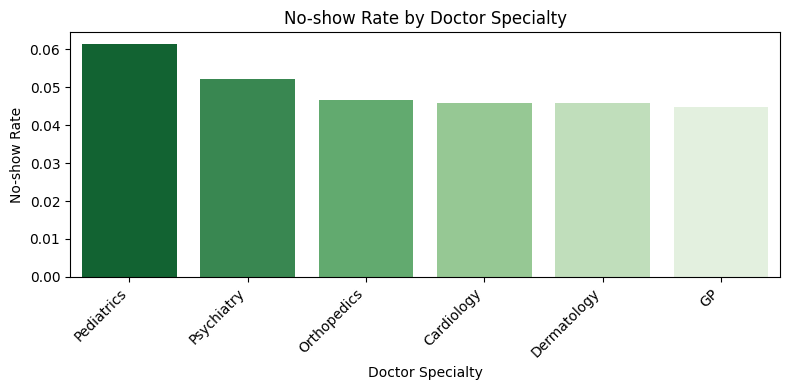

In [22]:
# Unify processing time and no_show_flag
appointments["appointment_datetime"] = pd.to_datetime(
    appointments["appointment_datetime"]
)
appointments["no_show_flag"] = (appointments["status"] == "no_show").astype(int)

# merge appointments & doctors
appt_doc = appointments.merge(
    doctors[["doctor_id", "specialty"]], on="doctor_id", how="left"
)

specialty_ns = (
    appt_doc.groupby("specialty")["no_show_flag"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(8,4))
sns.barplot(
    data=specialty_ns,
    x="specialty",
    y="no_show_flag",
    palette="Greens_r"
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Doctor Specialty")
plt.ylabel("No-show Rate")
plt.title("No-show Rate by Doctor Specialty")
plt.tight_layout()
plt.show()

# Visual 2 — Monthly trend of no-show rate
## “How does no-show rate change over time?”
### Why this chart?
We plot monthly no-show rates to see whether patient attendance fluctuates over time.
This helps us identify seasonal patterns or unusual spikes.
### Chart interpretation
The no-show rate varies month to month but generally stays within a narrow range (~4%-6%).
We notice a few peaks (e.g., 2024-08, 2025-08) suggesting months with higher risk.
### Insights
The chart helps us understanding time-based fluctuations helps clinics plan staff schedules, reminder campaigns, or flexible booking strategies during higher-risk months.Although the no-show rate fluctuates month-to-month, there is no dramatic seasonal pattern. The rate generally stays between 4-6%, though occasional peaks suggest short-term influences such as holidays, weather, or clinic backlog. Tracking the trend over time helps the clinic identify when no-show risk rises, enabling earlier interventions like reminder texts, online check-in options, or flexible scheduling.

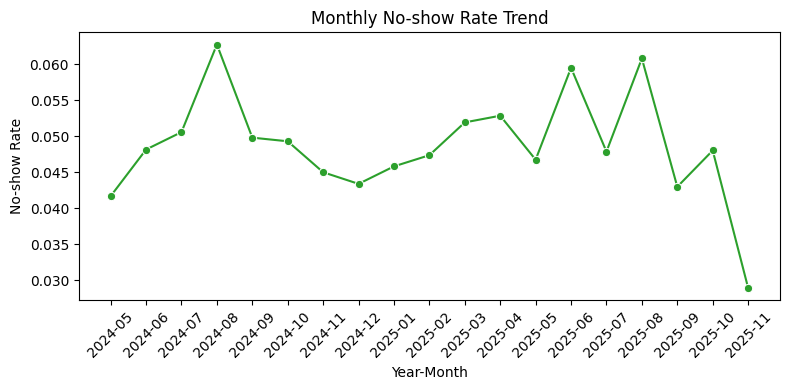

In [23]:
appointments["appointment_datetime"] = pd.to_datetime(appointments["appointment_datetime"])
appointments["year_month"] = appointments["appointment_datetime"].dt.to_period("M")

monthly_ns = (
    appointments.groupby("year_month")["no_show_flag"]
    .mean()
    .reset_index()
)

monthly_ns["year_month"] = monthly_ns["year_month"].astype(str)

plt.figure(figsize=(8,4))
sns.lineplot(
    data=monthly_ns,
    x="year_month",
    y="no_show_flag",
    marker="o",
    color="#2ca02c"
)
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("No-show Rate")
plt.title("Monthly No-show Rate Trend")
plt.tight_layout()
plt.show()

# Visual 3 — Distribution of Booking Lead Time by Attendance Outcome
## “Do late or early bookings increase the risk of no-shows?”
### Why this chart?
Lead time (days between registration and appointment) is a behavioral feature. Understanding when patients tend to miss appointments helps us judge whether timing impacts attendance.
### Chart interpretation
Most appointments are booked 100-1200 days after registration. No-show counts are very small and spread across the same range, meaning no-show likelihood doesn't spike at a specific lead time.
### Insights
The distribution shows that most appointments occur long after registration, and no-show rates do not rise significantly for early or late bookings. This suggests booking delays are not a main driver of no-shows in this dataset. Since lead time alone doesn't increase risk, clinics may focus instead on patient-specific factors (history, transportation barriers) rather than adjusting scheduling policies.

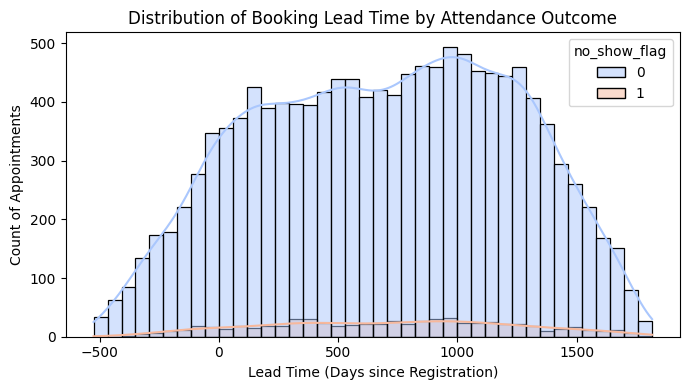

In [29]:
appt_pat = appointments.merge(
    patients[["patient_id", "registration_date"]],
    on="patient_id",
    how="left"
)

appt_pat["appointment_datetime"] = pd.to_datetime(appt_pat["appointment_datetime"])
appt_pat["registration_date"] = pd.to_datetime(appt_pat["registration_date"])

appt_pat["lead_days"] = (
    appt_pat["appointment_datetime"] - appt_pat["registration_date"]
).dt.days
plt.figure(figsize=(7,4))
sns.histplot(
    data=appt_pat,
    x="lead_days",
    hue="no_show_flag",
    kde=True,
    bins=40,
    palette="coolwarm"
)

plt.xlabel("Lead Time (Days since Registration)")
plt.ylabel("Count of Appointments")
plt.title("Distribution of Booking Lead Time by Attendance Outcome")
plt.tight_layout()
plt.show()

# Visual 4 — Heatmap of No-show vs Day & Time
## “When are patients most likely to miss appointments?”
### Why this chart?
We wanted to check whether no-shows are linked to specific days or time slots. Clinics often schedule peak hours, so identifying risky periods can support better planning and reminder strategies.
### Chart interpretation
The heatmap shows a noticeable variation across weekdays and hours. Saturday late morning (around 11 AM) has the highest no-show rate, while early weekday mornings are relatively safer.
### Insights
A patient's chance of missing an appointment depends not only on the day but also the time. Late mornings and mid-afternoons show slightly higher rates, which may reflect work or family conflicts. Weekend appointments appear riskier, especially Saturdays. This insight could guide scheduling policies, such as offering more telehealth visits during higher-risk hours or sending reinforced reminders for weekend slots.The clinic could target reminder messages or overbooking policies specifically around high-risk hours. Weekend scheduling may need stricter confirmation steps.

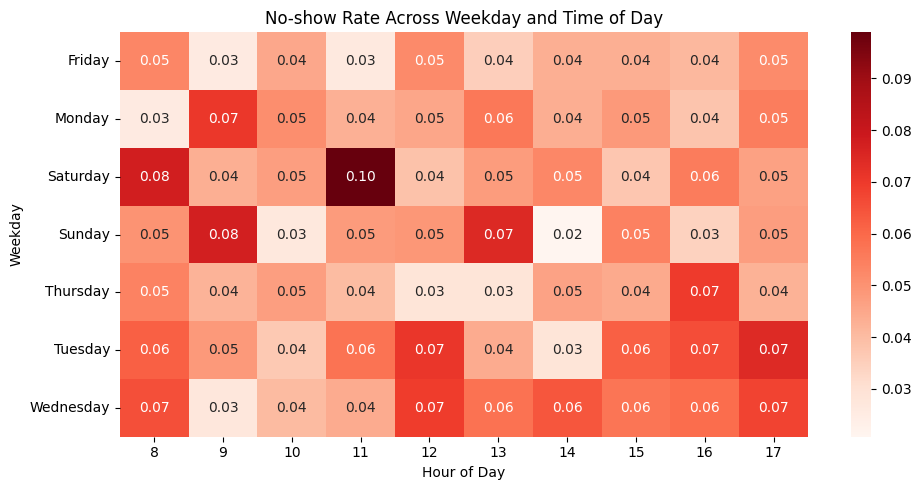

In [18]:
appointments["appointment_datetime"] = pd.to_datetime(appointments["appointment_datetime"])
appointments["weekday"] = appointments["appointment_datetime"].dt.day_name()
appointments["hour"] = appointments["appointment_datetime"].dt.hour

heat = (
    appointments.groupby(["weekday","hour"])["no_show_flag"]
    .mean()
    .reset_index()
    .pivot(index="weekday", columns="hour", values="no_show_flag")
)

plt.figure(figsize=(10,5))
sns.heatmap(heat, cmap="Reds", annot=True, fmt=".2f")
plt.title("No-show Rate Across Weekday and Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()

# Visual 5 - Future No-show Risk vs Patient No-show History
## “Does a history of missed appointments predict future no-shows?”
### Why this chart?
This chart explores whether patients who previously missed appointments are more likely to miss again in the future. Identifying this risk helps clinics plan reminder systems or targeted follow-ups.
### Chart interpretation
Patients with 0-4 prior no-shows have a relatively stable future no-show rate. Interestingly, when the number of past no-shows reaches 5 or 6, the rate drops sharply, likely due to very small sample sizes at those levels.
### Insights
Patients with even one past no-show are more likely to miss future visits, meaning no-show behavior tends to persist over time. This gives the clinic a clear signal: past behavior is a strong predictor of risk. Targeted interventions—for example, earlier reminder phone calls, SMS confirmations, or stricter rescheduling policies—could be applied specifically to these higher-risk patients to improve attendance.

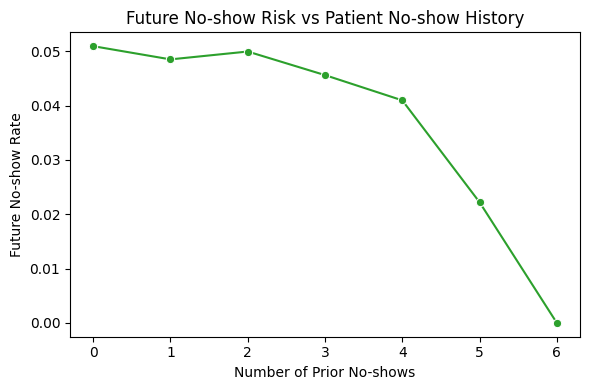

In [30]:
# Compute prior no-shows per patient
appt_sorted = appointments.sort_values("appointment_datetime")
appt_sorted["prior_no_shows"] = appt_sorted.groupby("patient_id")["no_show_flag"].cumsum() - appt_sorted["no_show_flag"]

# Now compute no-show rate by historical count
hist_no_show = (
    appt_sorted.groupby("prior_no_shows")["no_show_flag"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.lineplot(data=hist_no_show, x="prior_no_shows", y="no_show_flag", marker="o", color="#2ca02c")
plt.xlabel("Number of Prior No-shows")
plt.ylabel("Future No-show Rate")
plt.title("Future No-show Risk vs Patient No-show History")
plt.tight_layout()
plt.show()

In [3]:
#duplicate
df = pd.read_csv("training_data.csv")

print("Data shape:", df.shape)
print(df.head())

Data shape: (13580, 16)
   appointment_id  patient_id  doctor_id appointment_datetime  \
0               1         251         33  2024-05-26 09:58:18   
1               2         176         56  2024-05-26 15:29:40   
2               3         306         27  2024-05-26 12:07:41   
3               4         244          6  2024-05-26 15:03:23   
4               5         307          4  2024-05-26 09:22:29   

       reason_for_visit  attendance_failure  appointment_hour  \
0               anxiety                   1                 9   
1          flu symptoms                   0                15   
2  depression follow-up                   1                12   
3           child fever                   0                15   
4  depression follow-up                   0                 9   

   appointment_weekday gender  age           city  num_previous_appointments  \
0                    0      M    3        Chicago                         37   
1                    0      F   62

# Visual 6 - Correlation Matrix Heatmap

Numeric columns used for correlation: ['attendance_failure', 'appointment_hour', 'appointment_weekday', 'age', 'num_previous_appointments', 'num_previous_no_shows', 'num_prescriptions', 'num_invoices', 'avg_amount_paid']


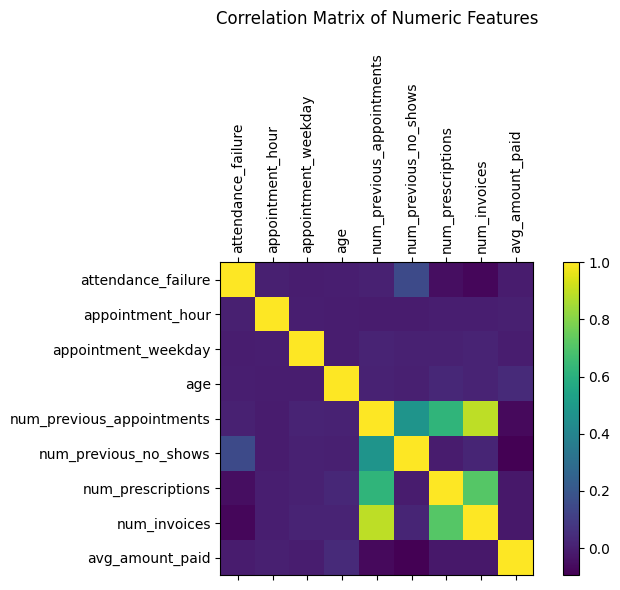

In [8]:
# Ensure target is numeric
df["attendance_failure"] = df["attendance_failure"].astype(int)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# remove id_columns
id_cols = ["appointment_id", "patient_id", "doctor_id"]
num_cols_for_corr = [c for c in num_cols if c not in id_cols]

print("Numeric columns used for correlation:", num_cols_for_corr)
num_df = df[num_cols_for_corr]

# Compute Pearson correlation matrix
corr_matrix = num_df.corr()
fig, ax = plt.subplots(figsize=(8, 6))

# Show correlation matrix as heatmap
cax = ax.matshow(corr_matrix, interpolation="nearest")

# Add colorbar
fig.colorbar(cax)

# Set ticks and labels
ticks = np.arange(len(corr_matrix.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

ax.set_title("Correlation Matrix of Numeric Features", pad=20)

plt.tight_layout()
plt.show()

num_previous_no_shows        0.153155
num_previous_appointments    0.005120
appointment_hour            -0.000212
age                         -0.003270
appointment_weekday         -0.008065
avg_amount_paid             -0.012802
num_prescriptions           -0.053067
num_invoices                -0.073619
Name: attendance_failure, dtype: float64


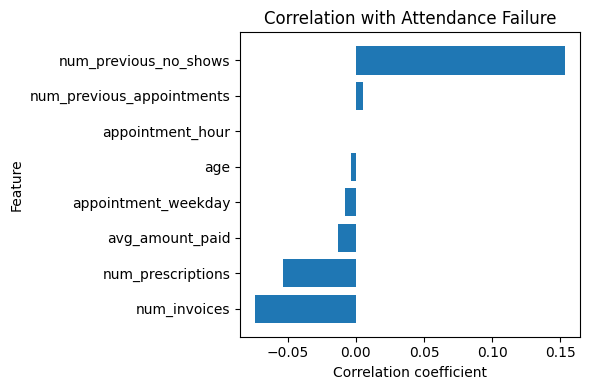

In [9]:
# Correlation of each numeric feature with the target
target = "attendance_failure"
corr_with_target = corr_matrix[target].drop(target).sort_values(ascending=False)
print(corr_with_target)

# Simple bar plot
plt.figure(figsize=(6, 4))
plt.barh(corr_with_target.index[::-1], corr_with_target.values[::-1])
plt.title("Correlation with Attendance Failure")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Insights

The correlation matrix shows that most numeric predictors have relatively weak linear relationships with each other and with the target variable, which supports the need for machine learning models capable of capturing nonlinear patterns. The strongest positive correlation with attendance failure is num_previous_no_shows, indicating that past behavior is the most reliable early signal of future no-shows.

Features such as num_prescriptions and num_invoices show slight negative correlations with the target, suggesting that patients more actively engaged in care or billing processes tend to attend appointments more reliably. Temporal variables such as appointment hour and weekday show minimal correlation, implying that operational scheduling factors alone are insufficient to predict no-shows.

These correlation results are consistent with the feature importance rankings observed in our Random Forest model in Task 3. Behavioral history features—rather than static demographics like age—have the highest predictive relevance. This insight validates the business strategy of prioritizing proactive outreach for patients with repeated missed appointments.

# Visual 7 - ML model visual

In [10]:
#duplicate
# 1. Target & features 
label_col = "attendance_failure"
df[label_col] = df[label_col].astype(int)

y = df[label_col]
X = df.drop(columns=[label_col, "appointment_datetime"])  

# 2. Train / test split（80/20 + stratify）
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=599,
    stratify=y
)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("encoder", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", rf_clf)
])

rf_pipe.fit(X_train, y_train)

Numeric cols: ['appointment_id', 'patient_id', 'doctor_id', 'appointment_hour', 'appointment_weekday', 'age', 'num_previous_appointments', 'num_previous_no_shows', 'num_prescriptions', 'num_invoices', 'avg_amount_paid']
Categorical cols: ['reason_for_visit', 'gender', 'city']


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['appointment_id',
                                                   'patient_id', 'doctor_id',
                                                   'appointment_hour',
                                                   'appointment_weekday', 'age',
                                                   'num_previous_appointments',
                                                   'num_previous_no_shows',
                                                   'num_prescriptions',
                                                   'num_invoices',
                                                   'avg_amount_paid']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['reason_for_visit', 'gender',
                                                   'city'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        n_jobs=-1, random_state=42))])

Top 10 important features:


,feature,importance
0,num_previous_no_shows,0.330706
1,appointment_id,0.112288
2,num_invoices,0.080531
3,doctor_id,0.065578
4,num_prescriptions,0.065136
5,num_previous_appointments,0.062078
6,patient_id,0.048359
7,avg_amount_paid,0.047277
8,reason_for_visit,0.044923
9,appointment_hour,0.042775


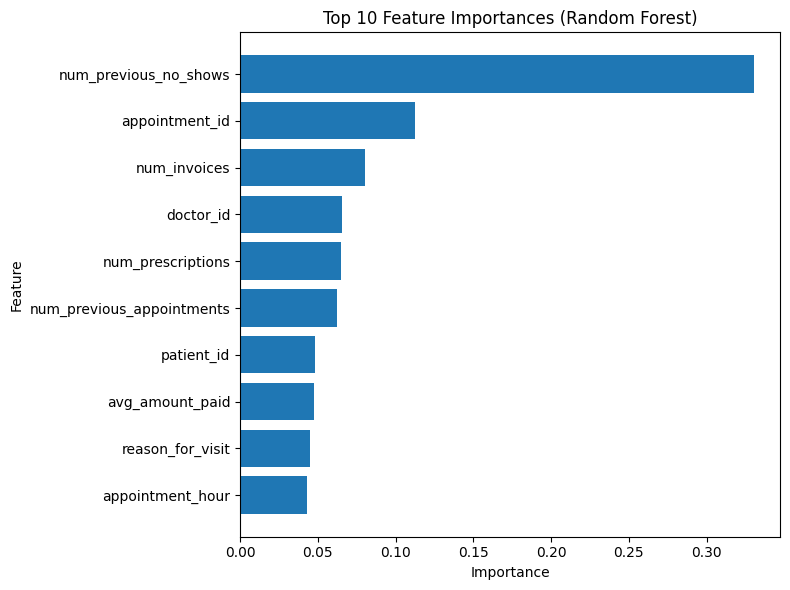

In [11]:
# ==== ML Model Visual 1: Feature Importances ====

# get RandomForest from pipeline
rf_final = rf_pipe.named_steps["clf"]

feature_names = num_cols + cat_cols

importances = rf_final.feature_importances_

# put into DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

print("Top 10 important features:")
display(fi_df.head(10))

top_n = 10
top_df = fi_df.head(top_n)

#draw Top 10 feature importance
plt.figure(figsize=(8, 6))
plt.barh(top_df["feature"][::-1], top_df["importance"][::-1])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Insights

The Random Forest model identifies past behavior variables as the strongest predictors of appointment attendance. Specifically, num_previous_no_shows holds a substantially higher importance value than all other features, confirming that patients with a history of missed appointments are significantly more likely to miss future visits.

Operational identifiers such as appointment_id and doctor_id also appear in the top predictors, which may reflect differences in scheduling logistics and physician-specific patient populations. Financial engagement variables and treatment activity show moderate contributions, suggesting that more financially and clinically engaged patients tend to attend reliably.

This evidence supports a behavior-based intervention strategy, where patients with repeated no-shows should be prioritized for proactive reminders, flexible scheduling, or follow-up phone calls to reduce wasted appointment capacity.

# ROC Curve

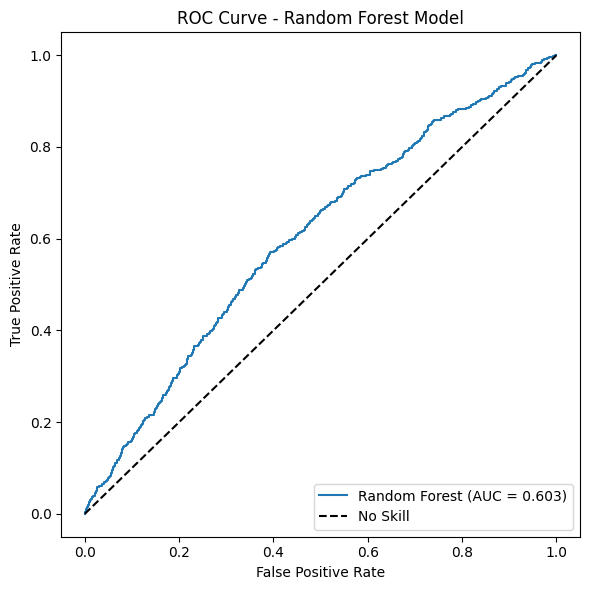

AUC: 0.6026098439457256


In [12]:
# ==== ML Model Visual 2: ROC Curve ====

from sklearn.metrics import roc_curve, auc

y_proba = rf_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="No Skill")

plt.title("ROC Curve - Random Forest Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("AUC:", roc_auc)

## Insights

The ROC curve demonstrates that the Random Forest model achieves an AUC of about 0.60, which is moderately above the no-skill baseline. This indicates that the model has limited but meaningful ability to differentiate between patients who will attend and those who may miss their appointments.

While the performance is not highly predictive, the model still provides actionable signal for early risk identification, particularly when combined with threshold tuning and operational policies. Improving model accuracy may require additional features such as reminder compliance distance to facility to better capture patient behavior patterns.